# Apprenticeship Capstone Project

For my final capstone project, I decided to take a look into the NCAA Men's March Madness Basketball Tournament. My goal was to find a way to predict the outcomes of the games based on different measures to then eventually be able to predict a better, more accurate bracket for a NCAA March Madness bracket pool. 

In [1]:
### Relevant imports ###
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

# Tournament Seed

### Data Cleaning and Preparation
After a lot of playing around with different datasets, I decided to use data provided by a Kaggle Data Competition focusing on March Madness. The competition provided participants with a variety of datasets, but for my personal project and idea, I only used a few and below are the main two for the following model:

**NCAATourneySeeds.csv**: includes Season, Seed, TeamID

**NCAATourneyCompact Results.csv**: includes Season, DayNum (what day the game was played on), WTeamID, WScore, LTeamID, LScore, WLoc (H: home, A: away, N: neutral), NumOT (number of overtime periods) 

In [2]:
## Load in relevant datasets
teams = pd.read_csv('data/Teams.csv')
seeds = pd.read_csv('data/NCAATourneySeeds.csv')
tourney = pd.read_csv('data/NCAATourneyCompactResults.csv')

In [3]:
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [4]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [5]:
tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Since the `Seed` column in the Tournament Seeds dataset is a string with additional characters, I created a new column, `SeedNum` with only the number portion of the seed column and then convert it from a string to a number. Then, I wanted to keep only the new, relevant seed column `SeedNum` so I dropped the `Seed` column.

In [6]:
seeds['SeedNum'] = seeds['Seed'].str[1:3]
seeds['SeedNum'] = pd.to_numeric(seeds['SeedNum'])
seeds.drop('Seed', inplace = True, axis=1)
seeds.head()

,Season,TeamID,SeedNum
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


After looking at the various columns that were provided in NCAA Tournament Compact Results dataset, I only wanted to focus on the winning and losing team IDS since the only variable I am focusing on is the seeding that is given in the `seeds` dataframe. So I took a subset of the columns from the tourney dataframe and only kept `Season`, `WTeamID` and `LTeamID`.

In [7]:
tourney_features = ['Season', 'WTeamID', 'LTeamID']
tourney = tourney[tourney_features]
tourney.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In order to get the seeds of the winning and losing team in the tourney dataframe, I need to merge the `seeds` and `tourney` dataframes. To prepare the `seeds` dataframe for merging, I created two new dataframes: `Wteams` for winning teams and `Lteams` for losing teams. I then renamed the `teamID` column to `WTeamID` for the `Wteams` dataframe and `LTeamID` for the `Lteams` dataframe. I did the name for the `SeedNum` column as well: `WSeedNum` for `Wteams` and `LSeedNum` for `Lteams`. Once the column names matched with all of the dataframes, I first merged the `tourney` dataframe with the `Wteams` using the commom column names of `Season` and `WteamID` and stored it in a temporary dataframe named `win_merge`. I then merged the temporary dataframe `win_merge` with the `Lteams` dataframe on the common column names `Season` and `LTeamID` to finally created a merged dataframe: `data`.

In [8]:
Wteams = seeds.rename(columns = {'TeamID':'WTeamID', 'SeedNum':'WSeedNum'})
Lteams = seeds.rename(columns = {'TeamID':'LTeamID', 'SeedNum':'LSeedNum'})
win_merge = pd.merge(left = tourney, right = Wteams, how = 'left', on = ['Season', 'WTeamID'])
data = pd.merge(left = win_merge, right = Lteams, how = 'left', on = ['Season', 'LTeamID'])
data.head()

,Season,WTeamID,LTeamID,WSeedNum,LSeedNum
0,1985,1116,1234,9,8
1,1985,1120,1345,11,6
2,1985,1207,1250,1,16
3,1985,1229,1425,9,8
4,1985,1242,1325,3,14


As I have said before, I wanted to look at seeding to then determine win/loss predictions. To evaluate seeding, I wanted to use the difference in seeds so I created a column `SeedDifference` that is the difference between the winning teams seed and the losing teams seed. 

In [9]:
data['SeedDifference'] = data['WSeedNum'] - data['LSeedNum']
data.head()

,Season,WTeamID,LTeamID,WSeedNum,LSeedNum,SeedDifference
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In order to perform a logistic regression, I need a target variable with binary values. I once again created temporary dataframes: `wins` for wins and `losses` for losses. I also, created the target variable `WinLoss` that will be a 1 for a win and a 0 for a loss. So the `WinLoss` column in the wins temporary dataframe is filled with 1s and in the losses temporary dataframe it is filled with 0s. Additionally, I am only keeping the `SeedDifference` column from data as that is the only metric I am focusing on for my regression. After filling the dataframes, I concatenated them into a dataframe called `seed_dataset`.

In [10]:
wins = pd.DataFrame()
wins['SeedDifference'] = data['SeedDifference']
wins['WinLoss'] = 1

losses = pd.DataFrame()
losses['SeedDifference'] = -data['SeedDifference']
losses['WinLoss'] = 0

In [11]:
seed_dataset = pd.concat([wins,losses])
seed_dataset.head()

,SeedDifference,WinLoss
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


### Building a Regression Model

I split the data first into `X` and `y`, and then into training and test sets. I did a default train test split which assigns 25% to the test set and set the `random_state` to 0.

In [12]:
# Split the data into target and predictors
y = seed_dataset['WinLoss']
X = seed_dataset.drop(columns=['WinLoss'], axis=1)

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [14]:
# Instantiate the model
logreg = LogisticRegression(fit_intercept = False, C=1e16, solver='liblinear')

# Fit the model
logreg.fit(X_train,  y_train)

LogisticRegression(C=1e+16, fit_intercept=False, solver='liblinear')

In [15]:
# Generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

### Evaluating The Logistic Regression Model

To evaluate my logistic regression, I first looked at residuals and looked at how many time was the classifier correct on the training set and then how many times it was correct on the test set.

In [16]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))

0    2251
1     924
Name: WinLoss, dtype: int64
------------------------------------
0    0.708976
1    0.291024
Name: WinLoss, dtype: float64


In [17]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))

0    766
1    293
Name: WinLoss, dtype: int64
------------------------------------
0    0.723324
1    0.276676
Name: WinLoss, dtype: float64


When looking at the residuals and percentage of accuracy, I can see for the training set there was a 70.9% accuracy by getting 2251 results correct and 924 incorrect. For the test set, it had a slightly higher accuracy of 72.33% getting 766 results correct and 293 incorrect 

I decided to look at a few other metrics to evaluate my model just to further evaluate it's performance.

**Precision** = number of true positives/number of predicted positives

**Recall** = number of true positives/number of actual total positives

**Accuracy** = (number of true positives + true negatives)/total observations

In [18]:
print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Precision:  0.7167213114754099
Testing Precision:  0.725897920604915



Training Recall:  0.689589905362776
Testing Recall:  0.7218045112781954



Training Accuracy:  0.7089763779527559
Testing Accuracy:  0.7233238904627006


The final metric I looked at was a confusion matrix which essentially just broke down the values that were already given in the residuals to true positives, true negatives, false positives, false negatives. 

In [19]:
# Print confusion matrix
cnf_matrix_train = confusion_matrix(y_train, y_hat_train)
print('Train Confusion Matrix:\n', cnf_matrix_train)
print('\n\n')

cnf_matrix_test = confusion_matrix(y_test, y_hat_test)
print('Test Confusion Matrix:\n', cnf_matrix_test)

Train Confusion Matrix:
 [[1158  432]
 [ 492 1093]]



Test Confusion Matrix:
 [[382 145]
 [148 384]]


### Putting it all together

After building, running and evaluating my model, I decided that a model with an average accuracy of about 70% was a decent model (and I didn't have that much time for this project to play around enough), I wanted to put the predictions from the regression model back into the original dataset `data`. I first used `predict_proba` to get the predictions from the whole matrix before the split. I created a column `WinPred` for the probability of the higher seeded team winning and `LossPred` for the probabilities of the higher seed team losing. Since the `seed_dataset` used for regression was a concatenate temporary dataset of a dataset of wins and a dataset of losses - the seed dataset has duplicate entries. The first half of the entries have the probabilities of the winning team winning and then the probabilities of the winning team losing. The second half of the entries are the probabilities of the losing team winning and the losing team losing - essentially the first half flipped. Therefore, to merge the probabilities with `data`, I only kept the first half of the data from `seed_dataset` and then merged them together using the common column `SeedDifference`.

In [20]:
seed_dataset['WinPred'] = [x[0] for x in logreg.predict_proba(X)]
seed_dataset['LossPred'] = [x[1] for x in logreg.predict_proba(X)]
seed_dataset.head()

,SeedDifference,WinLoss,WinPred,LossPred
0,1,1,0.541191,0.458809
1,5,1,0.695443,0.304557
2,-15,1,0.077481,0.922519
3,1,1,0.541191,0.458809
4,-11,1,0.139852,0.860148


In [21]:
seed_dataset = seed_dataset.iloc[0:2117]

In [22]:
final_seed_dataset = pd.merge(left = data, right = seed_dataset, how = 'left', on = ['SeedDifference'])
final_seed_dataset.drop('WinLoss', inplace=True, axis=1)
final_seed_dataset.head()

,Season,WTeamID,LTeamID,WSeedNum,LSeedNum,SeedDifference,WinPred,LossPred
0,1985,1116,1234,9,8,1,0.541191,0.458809
1,1985,1116,1234,9,8,1,0.541191,0.458809
2,1985,1116,1234,9,8,1,0.541191,0.458809
3,1985,1116,1234,9,8,1,0.541191,0.458809
4,1985,1116,1234,9,8,1,0.541191,0.458809


Finally, I wanted to be able to visualize this in some way so plotted a simplete scatter plot of `SeedDifference` and `WinPred`.

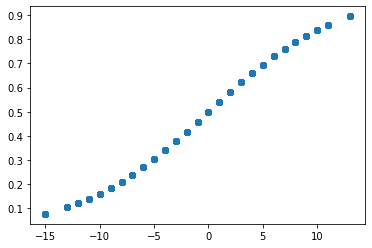

In [23]:
plt.scatter(final_seed_dataset['SeedDifference'], final_seed_dataset['WinPred']);

# Average Rank

Initially, I was planning on working with seeds and doing a regression based on SeedDifference. When I first created the model, it wasn't giving conclusive or great results. I thought it was based on the data I was using so I decided to look at the different data that was provided to the Kaggle Data Competition and found a dataset containing rankings. Once I went through and did a model with ranking data as well, I realized I was making a mistake with the way I was preparing the data for the regression and went and looked at my seed based regression and was able to fix my mistake. But I decided to continue with average rank data as well to continue to explore.

### Data Cleaning and Preparation
The data used for rankings was **MasseyOrdinals**. This zip file contains a large CSV file, listing out rankings (e.g. 1, 2, 3, ..., N) of teams going back to the 2002-2003 season, under a large number of different ranking system methodologies. The information was gathered by Kenneth Massey and provided on his College Basketball Ranking Composite page. This was a very large dataset and I was unable to load the entire csv to github. Therefore, I had decided to limit the dataset by only have the final ranking from each season which means the `max(RankingDayNum)` which is `133`. I did this in Excel and then loaded the Final dataset into Github. 

**MasseyOrdinalsFinal.csv**: includes Season, RankingDayNum (ranking up until that day), SystemName (what district ranking system rank is from), TeamID, OrdinalRank)

In [24]:
rankings = pd.read_csv('data/MasseyOrdinalsFinal.csv')
rankings.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,133,AP,1112,2
1,2003,133,AP,1163,23
2,2003,133,AP,1166,15
3,2003,133,AP,1173,16
4,2003,133,AP,1181,7


Since there is data over so many seasons, I wanted to use the average rank of a team going into the March Madness tournament. I found the average rankings by grouping by `Season` and `TeamID` and taking the average mean of `OrdinalRank` from the different ranking systems provided. I then replaced the column `OrdinalRank` with `AvgRank`.

In [25]:
rankings = rankings.groupby(['Season', 'TeamID'])['OrdinalRank'].mean()
rankings = rankings.reset_index()
rankings.rename(columns={'OrdinalRank':'AvgRank'}, inplace=True)
rankings.head()

,Season,TeamID,AvgRank
0,2003,1102,156.03125
1,2003,1103,168.00000
2,2003,1104,38.03125
3,2003,1105,308.96875
4,2003,1106,262.68750


Similar to what I did with the seeding, I combined the `rankings` data with the `tourney` data so I can now see the average ranks of the winning and losing team for each game. To do this, I created two new dataframes: `Wranks` for rankings of winning teams and `Lranks` for rankings of losing teams. I then renamed the `teamID` column to `WTeamID` for the `Wranks` dataframe and `LTeamID` for the `Lranks` dataframe. I did the name for the `AvgRank` column as well: `WAvgRank` for `Wranks` and `LAvgRank` for `Lranks`. Once the column names matched with all of the dataframes, I first merged the `tourney` dataframe with the `Wranks` using the commom column names of `Season` and `WteamID` and stored it in a temporary dataframe named `rank_merge`. I then merged the temporary dataframe `rank_merge` with the `Lranks` dataframe on the common column names `Season` and `LTeamID` to finally created a merged dataframe: `tourney_rankings`.

In [26]:
Wranks = rankings.rename(columns = {'TeamID':'WTeamID', 'AvgRank':'WAvgRank'})
Lranks = rankings.rename(columns = {'TeamID':'LTeamID', 'AvgRank':'LAvgRank'})
rank_merge = pd.merge(left = tourney, right = Wranks, how = 'left', on = ['Season', 'WTeamID'])
tourney_rankings = pd.merge(left = rank_merge, right = Lranks, how = 'left', on = ['Season', 'LTeamID'])
tourney_rankings = tourney_rankings.dropna()
tourney_rankings.head()

,Season,WTeamID,LTeamID,WAvgRank,LAvgRank
1136,2003,1421,1411,240.343750,239.281250
1137,2003,1112,1436,2.676471,153.125000
1138,2003,1113,1272,36.000000,21.705882
1139,2003,1141,1166,45.687500,20.735294
1140,2003,1143,1301,36.406250,50.312500


I created a column `RankDifference` to show the difference of rankings between the winning team and losing team and use that as a the metric in my regression model.

In [27]:
tourney_rankings['RankDifference'] = tourney_rankings['WAvgRank'] - tourney_rankings['LAvgRank']
tourney_rankings.head()

,Season,WTeamID,LTeamID,WAvgRank,LAvgRank,RankDifference
1136,2003,1421,1411,240.343750,239.281250,1.062500
1137,2003,1112,1436,2.676471,153.125000,-150.448529
1138,2003,1113,1272,36.000000,21.705882,14.294118
1139,2003,1141,1166,45.687500,20.735294,24.952206
1140,2003,1143,1301,36.406250,50.312500,-13.906250


In order to perform a logistic regression, I need a target variable with binary values. Similar to what I did with seeding, I once again created temporary dataframes: `rank_wins` for wins and `rank_losses` for losses. I also, created the target variable `WinLoss` that will be a 1 for a win and a 0 for a loss. So the `WinLoss` column in the wins temporary dataframe is filled with 1s and in the losses temporary dataframe it is filled with 0s. Additionally, I am only keeping the `RankDifference` column from data as that is the only metric I am focusing on for my regression. After filling the dataframes, I concatenated them into a dataframe called `rank_dataset`.

In [28]:
rank_wins = pd.DataFrame()
rank_wins['RankDifference'] = tourney_rankings['RankDifference']
rank_wins['WinLoss'] = 1

rank_losses = pd.DataFrame()
rank_losses['RankDifference'] = -tourney_rankings['RankDifference']
rank_losses['WinLoss'] = 0

In [29]:
rank_dataset = pd.concat([rank_wins,rank_losses])
rank_dataset.head()

,RankDifference,WinLoss
1136,1.062500,1
1137,-150.448529,1
1138,14.294118,1
1139,24.952206,1
1140,-13.906250,1


### Building a Logistic Regression Model

I split the data first into `X` and `y`, and then into training and test sets. I did a default train test split which assigns 25% to the test set and set the `random_state` to 0.

In [30]:
# Split the data into target and predictors
y2 = rank_dataset['WinLoss']
X2 = rank_dataset.drop(columns=['WinLoss'], axis=1)

In [31]:
# Split the data into training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=0)

In [32]:
# Instantiate the model
logreg2 = LogisticRegression(fit_intercept = False, C=1e12, solver='liblinear')

# Fit the model
logreg2.fit(X_train2,  y_train2)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [33]:
# Generate predictions
y_hat_train2 = logreg2.predict(X_train2)
y_hat_test2 = logreg2.predict(X_test2)

### Evaluating The Logistic Regression Model

To evaluate my logistic regression, I first looked at residuals and looked at how many time was the classifier correct on the training set and then how many times it was correct on the test set.

In [34]:
residuals = np.abs(y_train2 - y_hat_train2)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))

0    1064
1     407
Name: WinLoss, dtype: int64
------------------------------------
0    0.723317
1    0.276683
Name: WinLoss, dtype: float64


In [35]:
residuals = np.abs(y_test2 - y_hat_test2)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))

0    344
1    147
Name: WinLoss, dtype: int64
------------------------------------
0    0.700611
1    0.299389
Name: WinLoss, dtype: float64


When looking at the residuals and percentage of accuracy, I can see for the training set there was a 72.3% accuracy by getting 1064 results correct and 407 incorrect. For the test set, it had a slightly lower accuracy of 70.06% getting 344 results correct and 147 incorrect 

Similar to above, I also looking at precision, recall, accuracy and confusion matrices to get a better look at how the model performed.

In [36]:
print('Training Precision: ', precision_score(y_train2, y_hat_train2))
print('Testing Precision: ', precision_score(y_test2, y_hat_test2))
print('\n\n')

print('Training Recall: ', recall_score(y_train2, y_hat_train2))
print('Testing Recall: ', recall_score(y_test2, y_hat_test2))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train2, y_hat_train2))
print('Testing Accuracy: ', accuracy_score(y_test2, y_hat_test2))
print('\n\n')

Training Precision:  0.7208053691275168
Testing Precision:  0.7076271186440678



Training Recall:  0.7296195652173914
Testing Recall:  0.6816326530612244



Training Accuracy:  0.7233174711080897
Testing Accuracy:  0.7006109979633401





In [37]:
# Print confusion matrix
rank_cnf_matrix_train = confusion_matrix(y_train2, y_hat_train2)
print('Train Confusion Matrix:\n', rank_cnf_matrix_train)
print('\n\n')

rank_cnf_matrix_test = confusion_matrix(y_test2, y_hat_test2)
print('Test Confusion Matrix:\n', rank_cnf_matrix_test)

Train Confusion Matrix:
 [[527 208]
 [199 537]]



Test Confusion Matrix:
 [[177  69]
 [ 78 167]]


### Putting it all together

After building, running and evaluating my model, I decided that a model with an average accuracy of about 71% was a decent model to get predictions from. I would say that the model with ranking difference did slightly better than the seed difference. But the seeding model performed slightly better on the testing set versus training set whereas it was flipped for the ranking model. Once again, I wanted to put the predictions from the regression model back into the original dataset `final_dataset`. I first used `predict_proba` to get the predictions from the whole matrix before the split. I created a column `WinPred` for the probability of the higher average ranked team winning and `LossPred` for the probabilities of the lower average ranked team winning. Since the `rank_dataset` used for regression was a concatenate temporary dataset of a dataset of wins and a dataset of losses - the `rank_dataset` has duplicate entries. The first half of the entries have the probabilities of the winning team winning and then the probabilities of the winning team losing. The second half of the entries are the probabilities of the losing team winning and the losing team losing - essentially the first half flipped. Therefore, to merge the probabilities with `final_dataset`, I only kept the first half of the data from `rank_dataset` and then merged them together using the common column `RankDifference`.

In [38]:
rank_dataset['WinPred'] = [x[0] for x in logreg2.predict_proba(X2)]
rank_dataset['LossPred'] = [x[1] for x in logreg2.predict_proba(X2)]
rank_dataset.head()

,RankDifference,WinLoss,WinPred,LossPred
1136,1.062500,1,0.507270,0.492730
1137,-150.448529,1,0.016013,0.983987
1138,14.294118,1,0.596588,0.403412
1139,24.952206,1,0.664410,0.335590
1140,-13.906250,1,0.405970,0.594030


In [39]:
rank_dataset = rank_dataset.iloc[0:981]

In [40]:
final_dataset = pd.merge(left = tourney_rankings, right = rank_dataset, how = 'left', on = ['RankDifference'])
final_dataset.drop('WinLoss', inplace=True, axis=1)
final_dataset.head()

,Season,WTeamID,LTeamID,WAvgRank,LAvgRank,RankDifference,WinPred,LossPred
0,2003,1421,1411,240.343750,239.281250,1.062500,0.507270,0.492730
1,2003,1112,1436,2.676471,153.125000,-150.448529,0.016013,0.983987
2,2003,1113,1272,36.000000,21.705882,14.294118,0.596588,0.403412
3,2003,1141,1166,45.687500,20.735294,24.952206,0.664410,0.335590
4,2003,1143,1301,36.406250,50.312500,-13.906250,0.405970,0.594030


Finally, I wanted to be able to visualize this in some way so plotted a simplete scatter plot of `RankDifference` and `WinPred`.

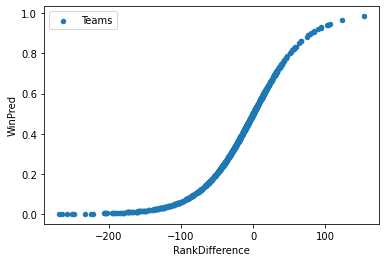

In [41]:
fig, ax = plt.subplots()
final_dataset.plot.scatter(x="RankDifference", y="WinPred", label="Teams", ax=ax)
ax.legend();

In [42]:
subset = final_dataset.loc[(final_dataset["RankDifference"]>-25) & (final_dataset["RankDifference"]<25)]
subset

,Season,WTeamID,LTeamID,WAvgRank,LAvgRank,RankDifference,WinPred,LossPred
0,2003,1421,1411,240.343750,239.281250,1.062500,0.507270,0.492730
2,2003,1113,1272,36.000000,21.705882,14.294118,0.596588,0.403412
3,2003,1141,1166,45.687500,20.735294,24.952206,0.664410,0.335590
4,2003,1143,1301,36.406250,50.312500,-13.906250,0.405970,0.594030
5,2003,1163,1140,27.500000,28.593750,-1.093750,0.492516,0.507484
...,...,...,...,...,...,...,...,...
975,2017,1376,1124,38.097222,14.346667,23.750556,0.657037,0.342963
977,2017,1332,1242,11.946667,6.040000,5.906667,0.540333,0.459667
978,2017,1314,1246,5.426667,4.813333,0.613333,0.504197,0.495803
981,2017,1314,1332,5.426667,11.946667,-6.520000,0.455501,0.544499


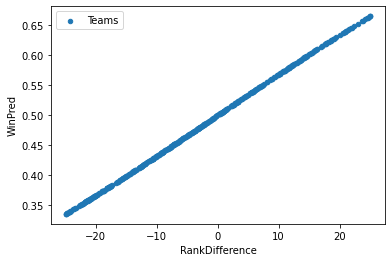

In [43]:
fig, ax = plt.subplots()
subset.plot.scatter(x="RankDifference", y="WinPred", label="Teams", ax=ax)
ax.legend();